In [24]:
import numpy as np
np.set_printoptions(linewidth=10000, threshold=10000)
import matplotlib.pyplot as plt

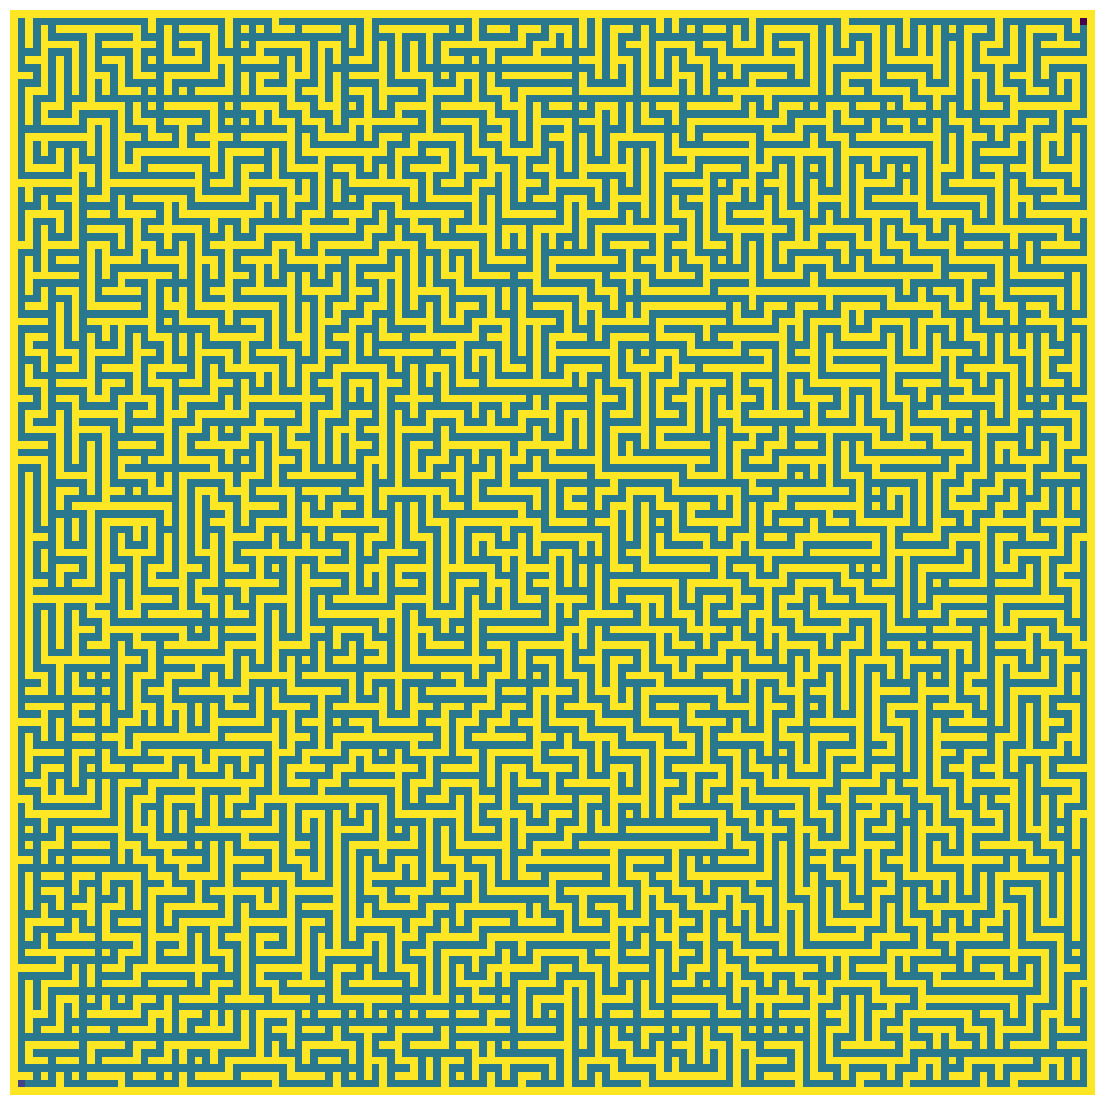

In [36]:
def numerize_map(amap):
    map_numer = np.zeros_like(amap, dtype=int)
    for pos in np.argwhere(amap=="S"):    map_numer[tuple(pos)] = -1
    for pos in np.argwhere(amap == "E"):  map_numer[tuple(pos)] = -2
    for pos in np.argwhere(amap=="#"):    map_numer[tuple(pos)] = 3
    return map_numer

def plot_map(amap: np.array, figsize = (4,4)):
    plt.rcParams['figure.figsize'] = figsize
    plt.matshow(amap, cmap='viridis')
    if amap.shape[0] < 50:
        plt.yticks(range(amap.shape[0]))
        plt.xticks(range(amap.shape[1]))
        plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(0.5))
        plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(0.5))
        plt.grid(axis="both", which="minor", linewidth=.5)
    else:
        plt.axis('off')

themap = np.genfromtxt('input16.txt', delimiter=1, comments=None, dtype=str)
themap = numerize_map(themap)
plot_map(themap, figsize=(14,14))

In [37]:
def out_directions(point: np.array, amap: np.array):
    dirs = [np.array((0, 1)), np.array((0, -1)), np.array((1, 0)), np.array((-1, 0))]
    return {tuple(dir) for dir in dirs if amap[tuple(point + dir)] != 3}

#build graph with map info on bifurcations, dead-ends removed
def build_map_graph(themap):
    start, end = tuple(np.argwhere(themap == -1)[0]), tuple(np.argwhere(themap == -2)[0])
    current_bifurcations, map_graph = {(start, dir) for dir in out_directions(start, themap)}, {}
    while current_bifurcations:
        point, dir = current_bifurcations.pop()
        edge_weight, dirs, previous = 0, {dir}, point
        while len(dirs) == 1:
            edge_weight += 1
            nextdir = np.array(dirs.pop())
            current = np.array(previous) + nextdir
            previous = tuple(current)
            dirs = out_directions(current, themap) - {tuple(-nextdir)}
            if previous == start: continue
            if previous == end  : break
            if len(dirs)==1 and max(dirs) != tuple(nextdir): edge_weight += 1000
        if len(dirs) > 0 or previous == end:
            if point in map_graph: map_graph[point].update({dir: (previous, tuple(-nextdir), edge_weight)})
            else: map_graph.update({point: {dir: (previous, tuple(-nextdir), edge_weight)}})
            if previous not in map_graph or tuple(-nextdir) not in map_graph[previous]:
                if previous != end: current_bifurcations.update({(tuple(current), dir) for dir in dirs})
    
    ##symmetrize
    for p1 in map_graph.copy().keys():
        for d1 in map_graph[p1].keys():
            (p2,d2,w) = map_graph[p1][d1]
            if p2 not in map_graph: map_graph.update({p2: {}})
            map_graph[p2].update({d2: (p1, d1, w)})
    del map_graph[end]
    
    ##correct first orientation
    if (start, (-1,0)) in map_graph:
        map_graph[(start, (-1,0))] = (map_graph[(start, (-1,0))][0], map_graph[(start, (-1,0))][1], map_graph[(start, (-1,0))][2]+1000)
    return map_graph, start, end

##pruning
def prune(map_graph:dict, start:tuple, end:tuple):
    keep_pruning = True
    while keep_pruning:
        keep_pruning = False
        for point in map_graph.copy():
            if point == start or point == end: continue
            for dir in map_graph[point].copy().keys():
                #loops
                if point in map_graph and dir in map_graph[point] and map_graph[point][dir][0] == point:
                    keep_pruning = True
                    del map_graph[point][map_graph[point][dir][1]]
                    del map_graph[point][dir]
                #not bifurcation
                if point in map_graph and len(map_graph[point])==2:
                    keep_pruning = True
                    subset = set(map_graph[point].items())
                    dpoint1, (p1,d1,w1) = subset.pop()
                    dpoint2, (p2,d2,w2) = subset.pop()
                    edge_weight = w1+w2
                    if dpoint1[0]**2 != dpoint2[0]**2: #enough to check if same direction
                        edge_weight += 1000
                    map_graph[p1].update({d1: (p2,d2,edge_weight)}); map_graph[p2].update({d2: (p1,d1,edge_weight)})
                    del map_graph[point]
                #dead-end (newly created from removal of the above)
                if point in map_graph and len(map_graph[point])==1:
                    dir = set(map_graph[point]).pop()
                    p,d,_ = map_graph[point][dir]
                    if p != end:
                        keep_pruning = True
                        del map_graph[point], map_graph[p][d]
    return map_graph


map_graph, start, end = build_map_graph(themap)
print(len(map_graph))
map_graph = prune(map_graph, start, end)
len(map_graph)

954


573

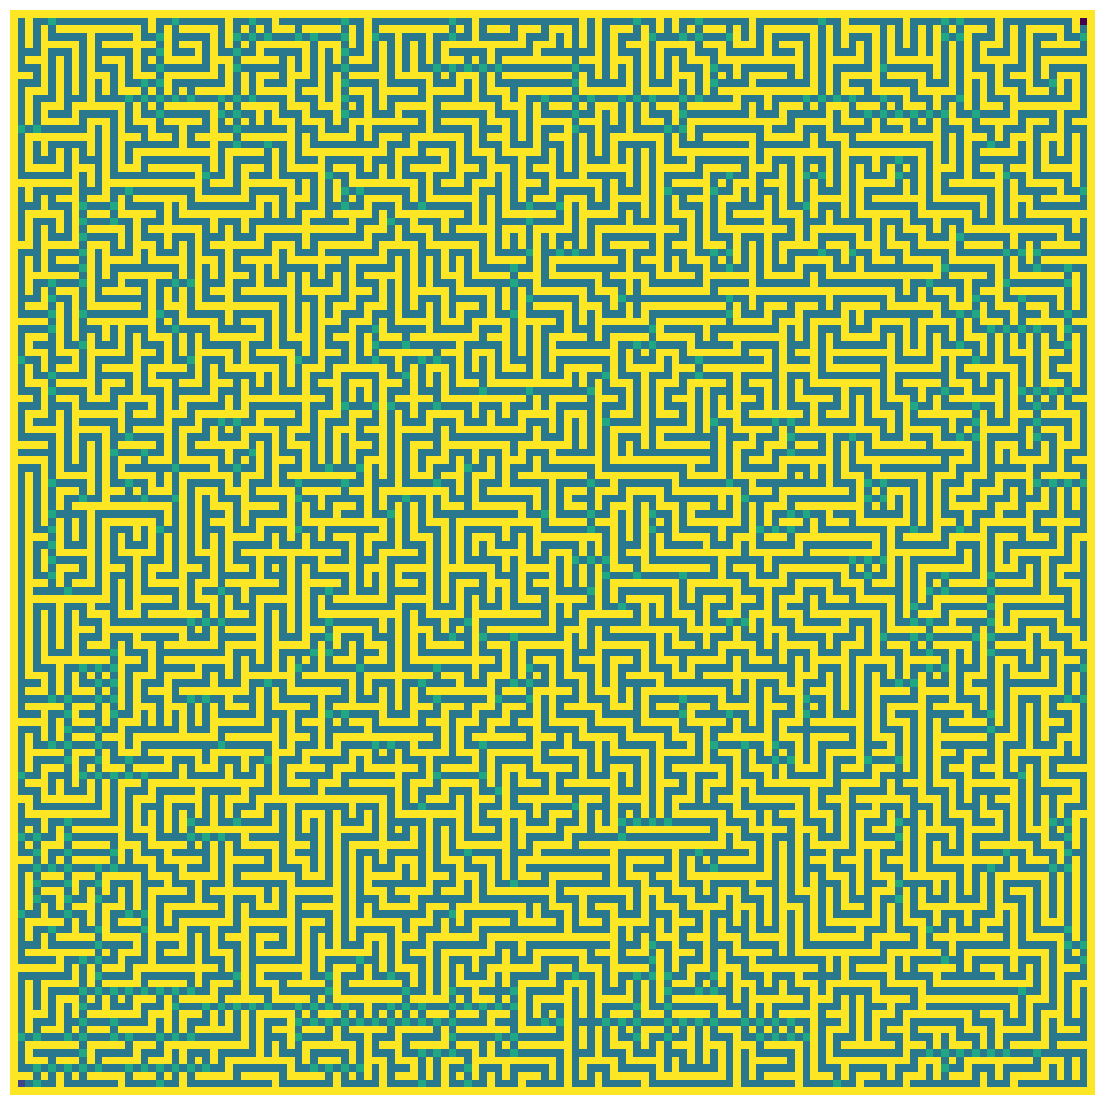

In [39]:
for point in map_graph:
    if point not in [start,end]:
        themap[point] = 1
plot_map(themap, figsize=(14,14))

Graph made and pruned. Now let's Dijkstra this thing!

In [40]:
#Dijkstra recording best path
def Dijkstra(map_graph:dict, start:tuple, end:tuple):
    #unvisited only registers horizontal or vertical directions (0 or 1, resp.)
    distances = {(point, dir[0]**2): (np.inf, []) for point in map_graph.keys() for dir in map_graph[point].keys()}
    distances.update({(end,0): (np.inf, []), (end,1): (np.inf, [])})
    if (start, 0) in distances: distances[(start, 0)] = (0, []) #distance and path
    if (start, 1) in distances: distances[(start, 1)] = (1000, [])
    unvisited = {point for point in map_graph.keys()}.union({end})

    next_up = {start}
    while next_up:
        mindist = min(v[0] for p,v in distances.items() if p[0] in next_up)
        curr_p = {p[0] for p,v in distances.items() if v[0]==mindist and p[0] in next_up}.pop()
        # print("curr_p",curr_p)
        next_up.remove(curr_p)
        unvisited.remove(curr_p)
        for curr_dir in map_graph[curr_p]:
            target, targ_dir, weight = map_graph[curr_p][curr_dir]
            # print(target, targ_dir, weight)
            distances[(target,   targ_dir[0]**2)] = min(distances[(target,   targ_dir[0]**2)],
                                                         (distances[(curr_p, curr_dir[0]**2)][0] + weight,
                                                           distances[(curr_p, curr_dir[0]**2)][1] + [curr_p]), key=lambda x: x[0])
            if target == end:
                return min(distances[end,i][0] for i in range(2) if (end,i) in distances), distances
            if target != start:
                distances[(target, 1-targ_dir[0]**2)] = min(distances[(target, 1-targ_dir[0]**2)],
                                                             (distances[(curr_p, curr_dir[0]**2)][0] + weight+1000,
                                                              distances[(curr_p, curr_dir[0]**2)][1] + [curr_p]), key=lambda x: x[0])
            if target in unvisited: next_up.add(target)
    return min(distances[end,i][0] for i in range(2) if (end,i) in distances), distances

# Dijkstra(map_graph, start, end)
length, distances = Dijkstra(map_graph, start, end)
a_path = [distances[end,i][1] for i in range(2) if (end,i) in distances and distances[end,i][0]==length][0]
length, a_path if len(a_path)<20 else "path too long"

(91464, 'path too long')

In [41]:
def path_tracer(begin, target, map_graph, themap):
    _, d1, _, d2, w = min([[begin, d1, target, d2, w] for d1, (p2, d2, w) in map_graph[begin].items() if p2 == target], 
            key=lambda data: data[4])
    current =  tuple(map(sum,zip(begin, d1)))
    traces, next_up, seen = [[current]], {current}, {begin}
    while next_up:
        current = next_up.pop()
        seen.add(current); new_dirs = out_directions(current, themap)
        new_points = {tuple(map(sum, zip(current, dir))) for dir in new_dirs} - seen
        if target in new_points:
            traces = [tr for tr in traces if tr[-1] == current]
            break
        if new_points == set(): #dead-end
            traces = [tr for tr in traces if tr[-1] != current]
        else:
            traces = [tr + [point] for tr in traces for point in new_points if (tr[-1]==current and point not in tr)] + \
                  [tr for tr in traces if tr[-1]!=current]
        next_up.update(new_points)
    if len(traces)==1: traces = traces[0]
    elif len(traces)==0: print("length 0???", begin, target)
    else: print("Multiple paths found")
    if w%1000 != len(traces)+1: print("Path length does not match weight")
    if tuple(map(sum, zip(target, d2))) != traces[-1]: print("Path does not reach target")
    return traces

464

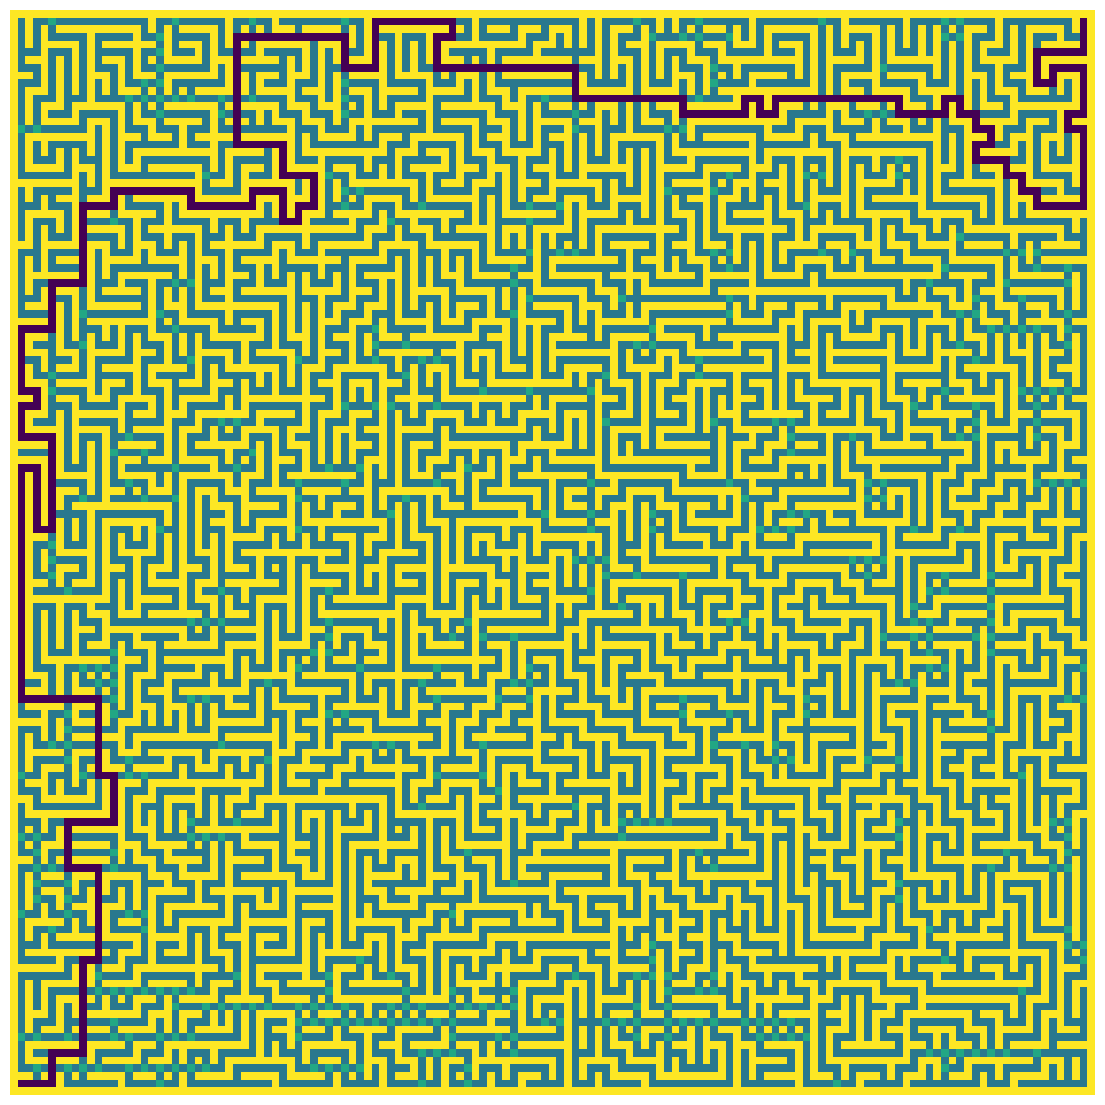

In [42]:
end_path = distances[end,1][1]
trace = set(end_path)
for i in range(len(end_path)-1):
    begin, target = end_path[i], end_path[i+1]
    trace.update(path_tracer(begin, target, map_graph, themap))
trace.update(path_tracer(end_path[-1], end, map_graph, themap))
for point in trace: themap[point] = -2
# for point in map_graph: themap[point] = 1
plot_map(themap, figsize=(14,14))
len(trace)

Part II - find all shortest paths

In [43]:
themap = np.genfromtxt('input16.txt', delimiter=1, comments=None, dtype=str)
themap = numerize_map(themap)
map_graph, start, end = build_map_graph(themap)
print(len(map_graph))
map_graph = prune(map_graph, start, end)
len(map_graph)

954


573

In [44]:
#Dijkstra, but recording all shortest paths
def Dijkstra_all(map_graph:dict, start:tuple, end:tuple):
    maxdist = Dijkstra(map_graph, start, end)[0]
    #unvisited only registers horizontal or vertical directions (0 or 1, resp.)
    distances = {(point, dir[0]**2): (np.inf, [[]]) for point in map_graph.keys() for dir in map_graph[point].keys()}
    distances.update({(end,0): (np.inf, [[]]), (end,1): (np.inf, [[]])})
    if (start, 0) in distances: distances[(start, 0)] = (0, [[]]) #distance and list of paths
    if (start, 1) in distances: distances[(start, 1)] = (1000, [[]])
    unvisited = {(point, v[0]**2) for point in map_graph.keys() for v in map_graph[point]}#.union({(end)})

    mindist = 0 if (start,0) in distances else 1000
    next_up = {(start, mindist//1000)} #gambiarra to set (start,0) or (start,1) knowing there's only one
    while mindist<maxdist: #stopping condition: no distance smaller than known start-to-end distance
        curr_p, curr_hv = {p for p,v in distances.items() if v[0]==mindist and p in next_up}.pop()
        if curr_p == end: print("break"); break #or stop if current point is the endpoint
        next_up.remove((curr_p, curr_hv))
        unvisited.remove((curr_p, curr_hv))
        for curr_dir in map_graph[curr_p]:
            if curr_dir[0]**2 != curr_hv: continue #only update on same direction (h or v), but both up&down (or L&R)
            target, targ_dir, weight = map_graph[curr_p][curr_dir]
            if (target, 0) in unvisited: next_up.add((target, 0))
            if (target, 1) in unvisited: next_up.add((target, 1))
            #same direction:
            old_dist = distances[(target,   targ_dir[0]**2)][0]
            new_dist = distances[(curr_p,   curr_dir[0]**2)][0] + weight
            if old_dist > new_dist:
                distances[(target,   targ_dir[0]**2)] = (new_dist,
                            [path + [curr_p] for path in distances[(curr_p, curr_dir[0]**2)][1]])
            elif old_dist == new_dist:
                distances[(target,   targ_dir[0]**2)] = (old_dist,
                            distances[(target,   targ_dir[0]**2)][1]+ \
                                [path + [curr_p] for path in distances[(curr_p, curr_dir[0]**2)][1]])
            if target == start: continue
            #perpendicular direction:
            old_dist = distances[(target, 1-targ_dir[0]**2)][0]
            new_dist = new_dist + 1000
            if old_dist > new_dist:
                distances[(target, 1-targ_dir[0]**2)] = (new_dist,
                            [path + [curr_p] for path in distances[(curr_p, curr_dir[0]**2)][1]])
            elif old_dist == new_dist:
                distances[(target, 1-targ_dir[0]**2)] = (old_dist,
                            distances[(target, 1-targ_dir[0]**2)][1]+\
                                [path + [curr_p] for path in distances[(curr_p, curr_dir[0]**2)][1]])
            
        mindist = min(v[0] for p,v in distances.items() if p in next_up) if next_up else np.Inf
    return [distances[end,i] for i in range(2) if (end,i) in distances and distances[end,i][0]==maxdist], distances

shortest, distances = Dijkstra_all(map_graph, start, end)
if shortest[0][0] != Dijkstra(map_graph, start, end)[0]: print("something wrong")
short_paths = shortest[0][1]
shortest[0][0], shortest[0][1] if len(shortest[0][1])<5 else len(shortest[0][1])

(91464, 54)

494

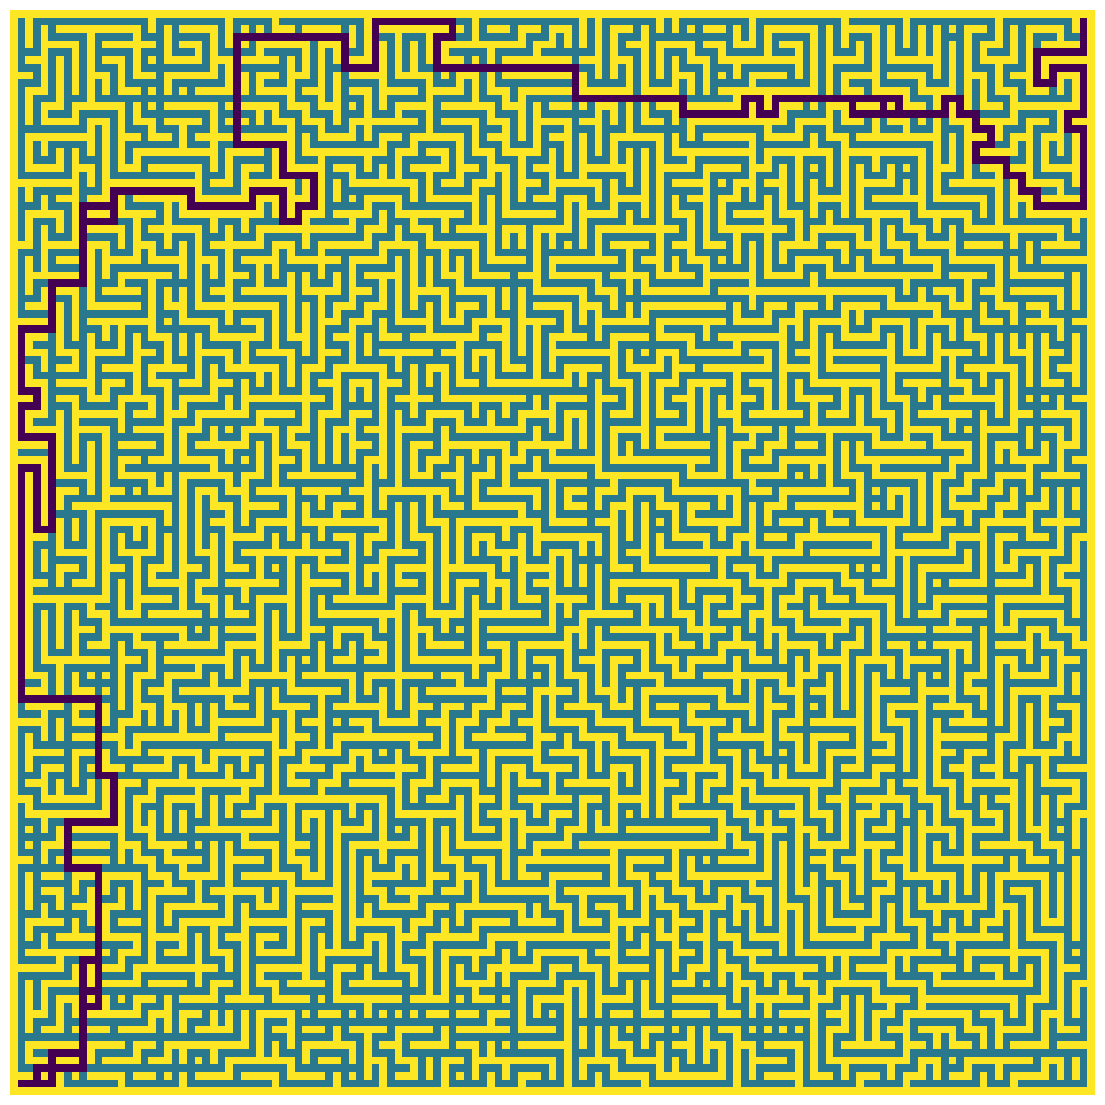

In [45]:
trace = {end}
for path in short_paths:
    trace.update(path)
    for i in range(len(path)-1):
        begin, target = path[i], path[i+1]
        trace.update(path_tracer(begin, target, map_graph, themap))
    trace.update(path_tracer(path[-1], end, map_graph, themap))
for point in trace: themap[point] = -2
# for point in map_graph: themap[point] = 1
plot_map(themap, figsize=(14,14))
len(trace)